In [623]:
import diplib as dip
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import re

In [624]:
matplotlib.rcParams['font.family'] = 'STIXGeneral'
root = 'images'

In [598]:
def parse_filename(filename):
    pattern = r'_(\d\d)(.*)\.tif'
    match_obj = re.search(pattern, filename)
    return match_obj.groups()


def parse_new_image(images, incoming_img, label):
    img_number, descriptor = label
    if descriptor.strip() == 'flipped': # we ignore it for now
        return images
    img = incoming_img
    if img_number in images.keys():
        img = (images[img_number] + incoming_img) / 2
    images[img_number] = img
    return images


def min_max_rescale(img):
    # rescale to 0..1
    return (img - np.min(img)) / (np.max(img) - np.min(img)) 


def get_location_of_largest_object(labeled_img, target_img):
    msr = dip.MeasurementTool.Measure(labeled_img, target_img,
                                      ['Gravity', 'Size'])
    size_argmax = np.argmax(msr['Size']) + 1
    y, x = np.array(msr[size_argmax]['Gravity']).astype(int)
    return x, y


def create_point_seed(x, y, shape, margin=10):
    seed = np.zeros(shape)
    seed[x-margin:x+margin, y-margin:y+margin] = 1  
    seed = dip.FixedThreshold(dip.Image(seed), 0.5)
    return seed


def isolate_largest_object(labeled_img, target_img, segmented_img):
    x, y = get_location_of_largest_object(labeled_img, target_img)
    seed_shape = target_img.Sizes()[::-1]
    seed = create_point_seed(x, y, seed_shape)
    filtered_img = dip.BinaryPropagation(seed, segmented_img)
    return filtered_img, (x, y)


def crop_based_on_object(segmented_img, raw_img):
    labeled_img = dip.Label(segmented_img)
    bbox = dip.GetLabelBoundingBox(labeled_img, 1)
    return segmented_img[bbox], raw_img[bbox]


def apply_segmentation(img):
    # segment only based on blue channel
    blue_img = dip.Image(np.array(img)[:, :, 2])                      
    blue_img[blue_img > 0.5] = 0.5 # cut off too high values
    # Smooth out to decrease background noise
    smooth_blue = dip.ConvolveFT(blue_img, np.ones((5, 5)))
    smooth_blue = dip.ContrastStretch(smooth_blue)
    segmented_img = dip.OtsuThreshold(smooth_blue)

    labeled_img = dip.Label(segmented_img, connectivity=1, minSize=100)
    filtered_img, center = isolate_largest_object(labeled_img,
                                                  blue_img,
                                                  segmented_img)
    return filtered_img, center

In [613]:
images = {}
for fn in os.listdir(root):
    incoming_img = dip.ImageReadTIFF(os.path.join(root, fn))
    label = parse_filename(fn)
    scaled_img = min_max_rescale(incoming_img)
    images = parse_new_image(images, scaled_img, label)

In [614]:
segmented_images = {}
for img_number in images.keys():
    segmented_img, _ = apply_segmentation(images[img_number])
    segmented_images[img_number] = segmented_img

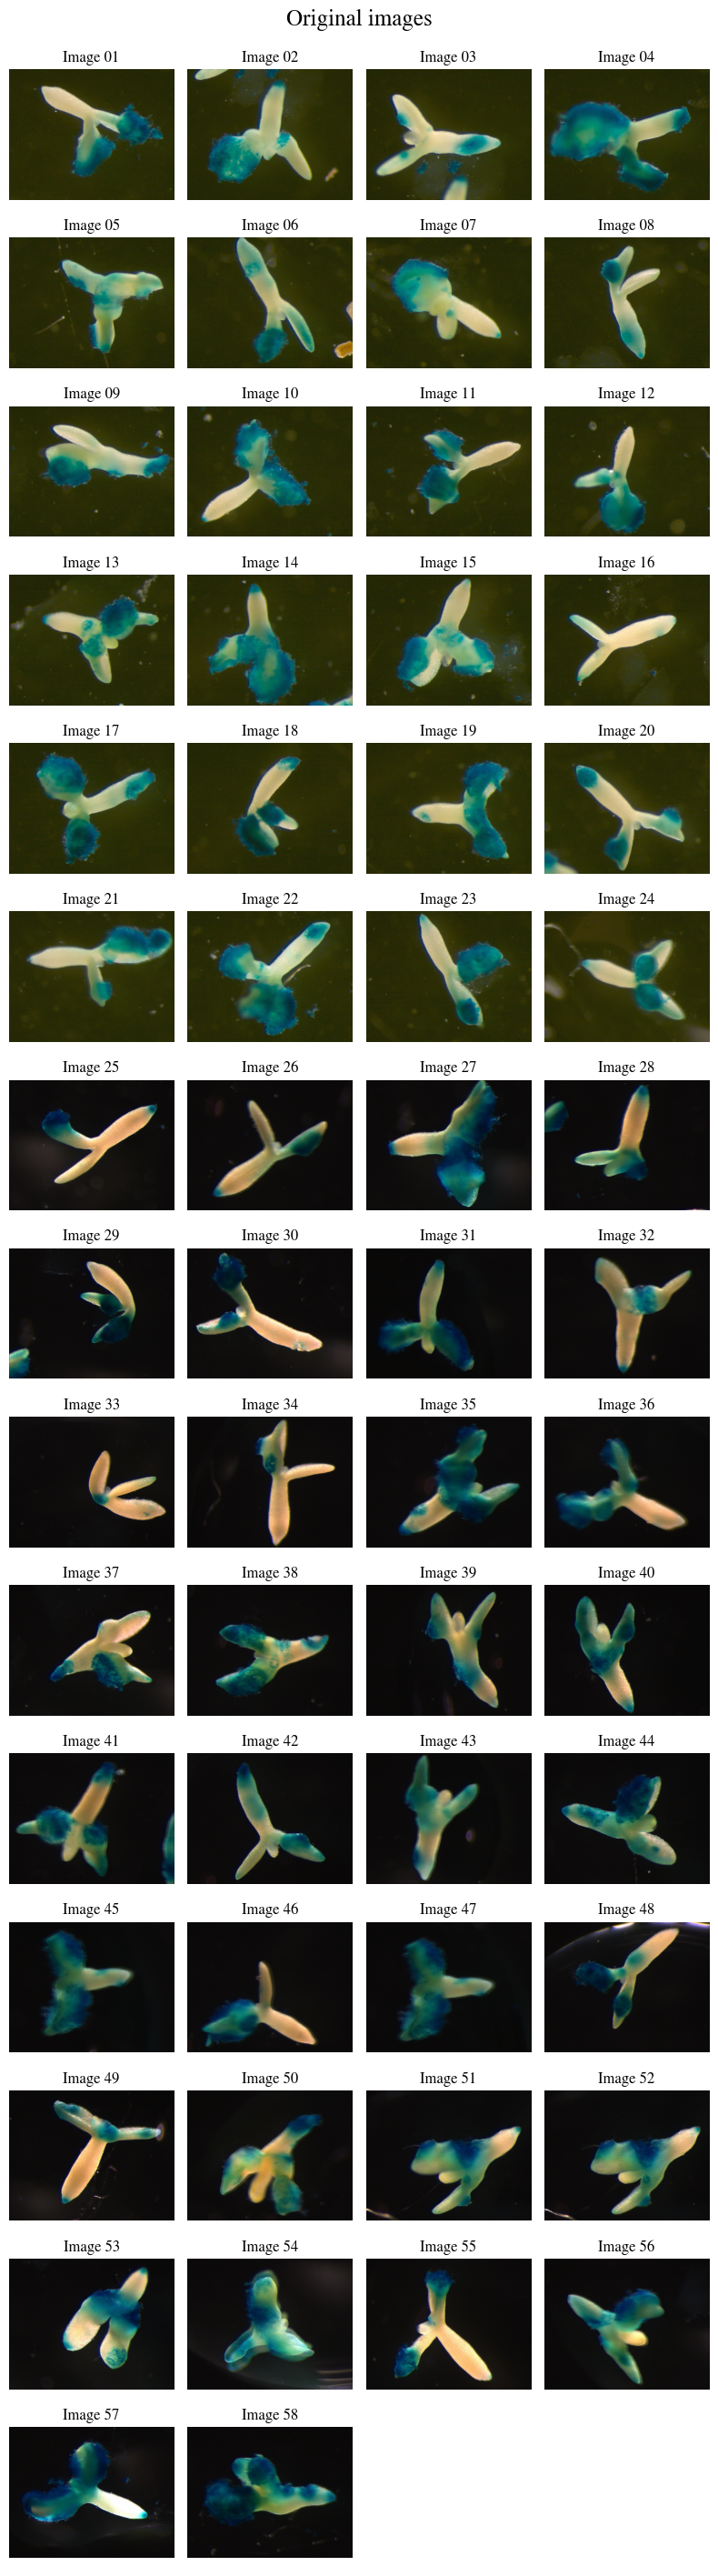

In [628]:
fig, axs = plt.subplots(15, 4, figsize=(8, 28))
axs = axs.flatten()
for idx, k in enumerate(sorted(images.keys())):
    axs[idx].imshow(images[k], origin='lower')
    # axs[idx].imshow(segmented_images[k], cmap='Reds', origin='lower', alpha=0.4)
    axs[idx].set_title(f'Image {k}')

[ax.axis('off') for ax in axs]
plt.tight_layout()
plt.suptitle('Original images', y=1.01, fontsize=18)
plt.show()


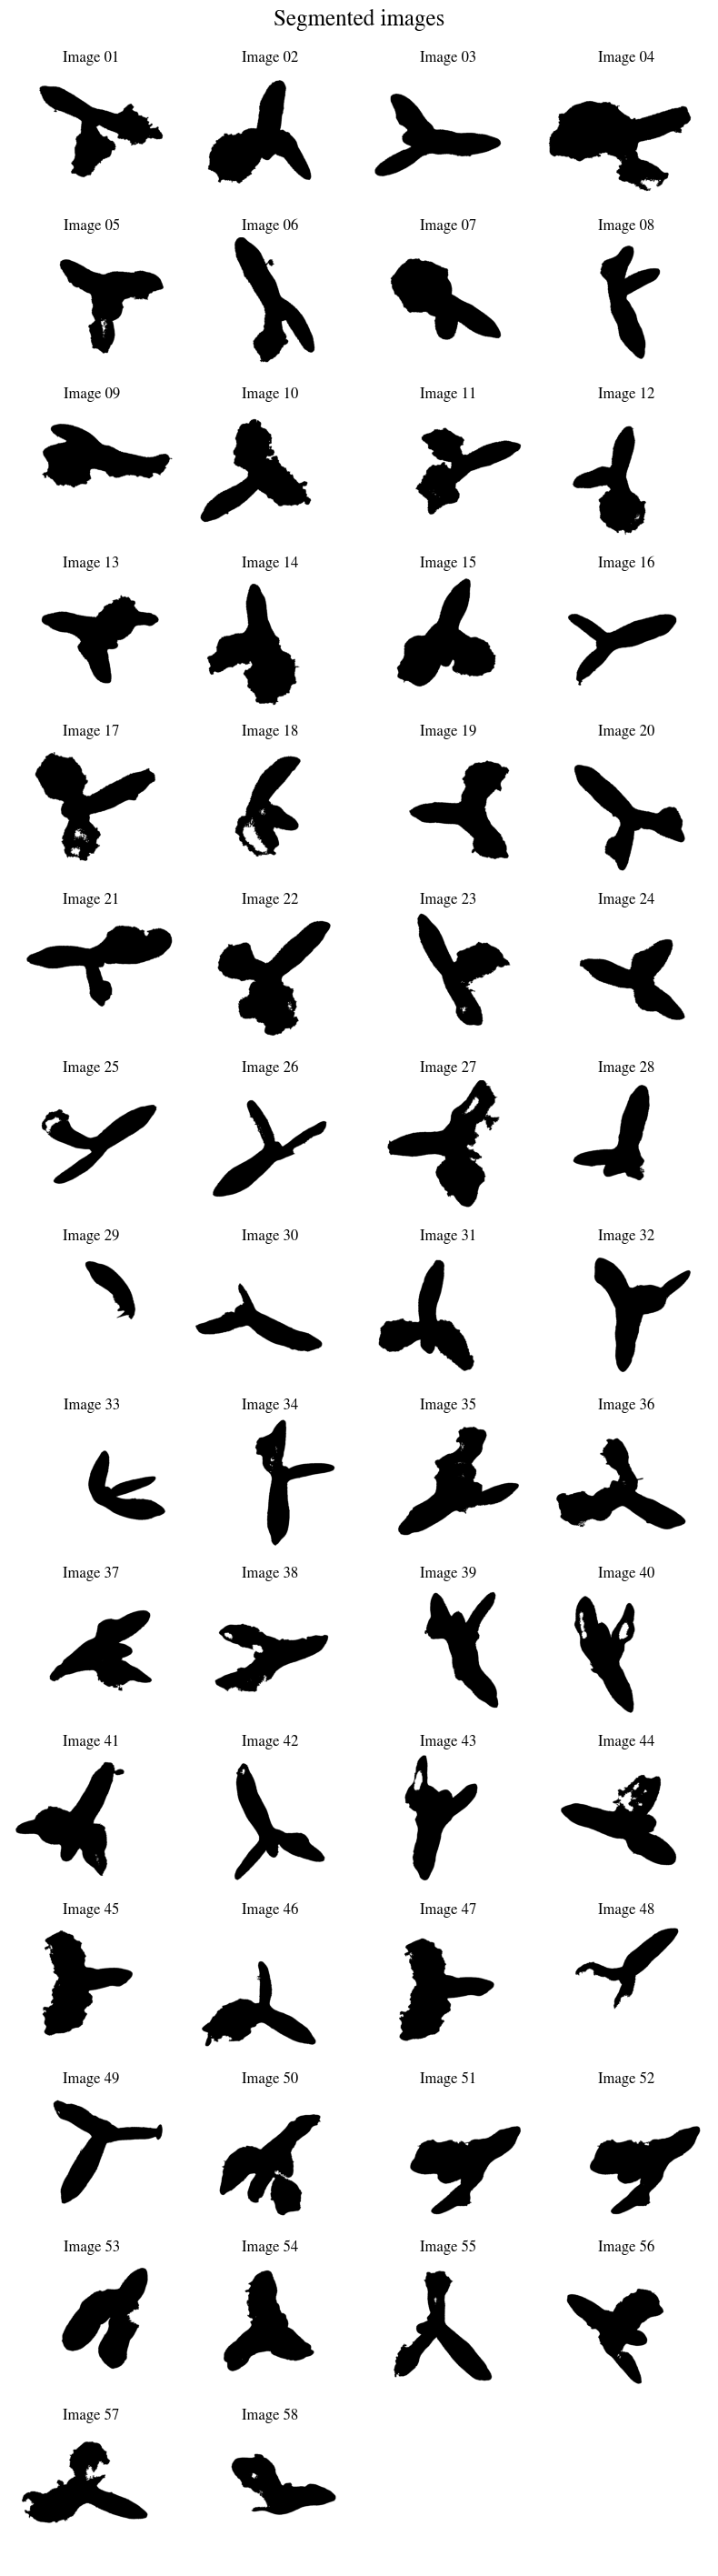

In [631]:
fig, axs = plt.subplots(15, 4, figsize=(8, 28))
axs = axs.flatten()
for idx, k in enumerate(sorted(segmented_images.keys())):
    axs[idx].imshow(-segmented_images[k], cmap='grey', origin='lower')
    axs[idx].set_title(f'Image {k}')

[ax.axis('off') for ax in axs]
plt.tight_layout()
plt.suptitle('Segmented images', y=1.01, fontsize=18)
plt.show()
